In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
from typing import Tuple , Union
import numpy as np

# LayerNorm

class LayerNorm(nn.LayerNorm):
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)
    
# QuickGELU

class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * torch.sigmoid(1.702 * x)
    

# ResidualAttentionBlock

class ResidualAttentionBlock(nn.Module):
    
    def __init__(self, d_model: int, n_head: int, attn_mask: Union[torch.Tensor, None] = None):
        super().__init__()
        
        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(
            OrderedDict([
                ("c_fc", nn.Linear(d_model, d_model * 4)),
                ("gelu", QuickGELU()),
                ("c_proj", nn.Linear(d_model * 4, d_model)),
            ])
        )
        
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask
        
    def attention(self, x: torch.Tensor) -> torch.Tensor:
        
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        
        return self.attn(x,x,x, need_weights=False, attn_mask=self.attn_mask)[0]
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        
        return x
    
# Transformer

class Transformer(nn.Module):
    
    def __init__(self, width:int, layers: int, heads: int, attn_mask: Union[torch.Tensor, None] = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(
            *[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)]
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resblocks(x)
    
    
# VisionTransformer

class VisionTransformer(nn.Module):
    
    def __init__(self, input_resolution:int , patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias = False)
        
        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)
        
        self.transformer = Transformer(width, layers, heads)
        self.ln_post = LayerNorm(width)
        
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = self.conv1(x) # shape [*, width, GridH, GridW]
        x = x.reshape(x.shape[0], x.shape[1], -1) # shape [*, width, GridH * GridW]
        x = x.permute(0, 2, 1) # shape [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros((x.shape[0], 1, x.shape[2]), device=x.device, dtype=x.dtype), x], dim=1) # shape [*, grid ** 2 + 1, width]
        
        x = x + self.positional_embedding.to(x.dtype) # shape [*, grid ** 2 + 1, width]
        x = self.ln_pre(x)
        
        x = x.permute(1, 0, 2) # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2) # LND -> NLD
        
        x = self.ln_post(x[:, 0, :]) # take the class token
        
        if self.proj is not None:
            x = x @ self.proj
            
        return x
    

# CLIPVisionTransformer

class CLIP(nn.Module):
    
    def __init__(
        self, 
        embed_dim: int,
        #vision
        image_resolution: int,
        vision_layers: Union[Tuple[int, int, int, int], int],
        vision_width: int,
        vision_patch_size: int,
        #text
        context_length: int,
        vocab_size: int,
        transformer_width: int,
        transformer_heads: int,
        transformer_layers: int,
    ):
        
        super().__init__()
        
        self.context_length = context_length
        
        print(vision_width)
        
        vision_head = vision_width // 64
        self.visual = VisionTransformer(
            input_resolution=image_resolution,
            patch_size=vision_patch_size,
            width=vision_width,
            layers=vision_layers,
            heads=vision_head,
            output_dim=embed_dim
        )
        
        self.tranformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )
        
        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)
        
        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        
        self.initialize_parameters()
        
        
    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)
        
        proj_std = (self.tranformer.width ** -0.5) * ((2 * self.tranformer.layers) ** -0.5)
        attn_std = self.tranformer.width ** -0.5
        fc_std = (2 * self.tranformer.width) ** -0.5
        for block in self.tranformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)
            
        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.tranformer.width ** -0.5)
            
    def build_attention_mask(self) -> torch.Tensor:
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1) # Zeros out the lower triangle, leaving the upper triangle as -inf
        return mask
    
    @property
    def dtype(self) -> torch.dtype:
        return self.visual.conv1.weight.dtype
    
    def encode_image(self, image: torch.Tensor) -> torch.Tensor:
        return self.visual(image.type(self.dtype))
    
    def encode_text(self, text: torch.Tensor) -> torch.Tensor:
        x = self.token_embedding(text).type(self.dtype) # [Batch_size, n_ctx, d_model]
        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2) # NLD -> LND
        x = self.tranformer(x)
        x = x.permute(1, 0, 2) # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection 
        
        return x
    
    def forward(self, image: torch.Tensor, text: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)
        
        # normalize features
        image_features = image_features / image_features.norm(dim = 1, keepdim=True)
        text_features = text_features / text_features.norm(dim = 1, keepdim=True)
        
        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()
        
        return logits_per_image, logits_per_text
    
    
def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""
    
    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()
                
        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k","bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()
                    
        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                tensor = getattr(l, name)
                if tensor is not None:
                    tensor.data = tensor.data.half()
                    
    model.apply(_convert_weights_to_fp16)
                
                
def build_model(state_dict: dict):
    """Builds a CLIP model from a state_dict"""
    
    vision_width = state_dict["visual.conv1.weight"].shape[0]
    vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
    
    vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
    grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
    image_resolution = vision_patch_size * grid_size
    
    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict.keys() if k.startswith("tranformer.resblocks")))
                             
    
    model = CLIP(
        embed_dim=embed_dim,
        image_resolution=image_resolution,
        vision_layers=vision_layers,
        vision_width=vision_width,
        vision_patch_size=vision_patch_size,
        context_length=context_length,
        vocab_size=vocab_size,
        transformer_width=transformer_width,
        transformer_heads=transformer_heads,
        transformer_layers=transformer_layers
    )
    
    for key in ["input_resolution", "contexT_lenght", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]
    
    convert_weights(model)
    model.load_state_dict(state_dict, strict=False)
    
    return model.eval()

    

In [10]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer  # You can switch to a simpler tokenizer if needed
import os

# --------------- Dataset ----------------
class CLIPDataset(Dataset):
    def __init__(self, csv_path, tokenizer, image_transform, context_length=77):
        self.data = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.context_length = context_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["file_path"]
        caption = str(self.data.iloc[idx]["text"])

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.image_transform(image)

        # Tokenize text
        tokens = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.context_length,
            return_tensors="pt"
        )
        text_tensor = tokens["input_ids"].squeeze(0)

        return image, text_tensor

# --------------- Prepare Data ----------------
def get_dataloader(csv_path, tokenizer, batch_size=32, context_length=77, image_size=224):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                             std=[0.26862954, 0.26130258, 0.27577711])
    ])

    dataset = CLIPDataset(csv_path, tokenizer, transform, context_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# --------------- Loss Function ----------------
def clip_loss(similarity: torch.Tensor) -> torch.Tensor:
    labels = torch.arange(len(similarity)).to(similarity.device)
    loss_i = nn.CrossEntropyLoss()(similarity, labels)
    loss_t = nn.CrossEntropyLoss()(similarity.T, labels)
    return (loss_i + loss_t) / 2

# --------------- Training ----------------
def train_clip(
    model, dataloader, epochs=10, lr=5e-5, device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    model.train()

    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, texts in pbar:
            images, texts = images.to(device), texts.to(device)

            logits_per_image, logits_per_text = model(images, texts)
            similarity = logits_per_image

            loss = clip_loss(similarity)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

# --------------- Main ----------------
if __name__ == "__main__":

    # Define model configuration
    model = CLIP(
        embed_dim=512,
        image_resolution=224,
        vision_layers=12,
        vision_width=768,
        vision_patch_size=16,
        context_length=77,
        vocab_size=30522,  # BERT base vocab size
        transformer_width=512,
        transformer_heads=8,
        transformer_layers=12,
    )

    # CSV with 'file_path' and 'text' columns
    csv_path = "/home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/cleaned_sample.csv"

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataloader = get_dataloader(csv_path, tokenizer, batch_size=32)

    train_clip(model, dataloader, epochs=10)


768


Epoch 1/10: 100%|██████████| 220/220 [00:40<00:00,  5.39it/s, loss=2.96]


Epoch 1: Avg Loss = 3.4682


Epoch 2/10: 100%|██████████| 220/220 [00:39<00:00,  5.50it/s, loss=2.9] 


Epoch 2: Avg Loss = 3.3323


Epoch 3/10: 100%|██████████| 220/220 [00:39<00:00,  5.53it/s, loss=2.65]


Epoch 3: Avg Loss = 3.0135


Epoch 4/10: 100%|██████████| 220/220 [00:39<00:00,  5.54it/s, loss=1.73]


Epoch 4: Avg Loss = 2.6067


Epoch 5/10: 100%|██████████| 220/220 [00:39<00:00,  5.54it/s, loss=1.96]


Epoch 5: Avg Loss = 2.2108


Epoch 6/10: 100%|██████████| 220/220 [00:39<00:00,  5.53it/s, loss=1.57]


Epoch 6: Avg Loss = 1.9071


Epoch 7/10: 100%|██████████| 220/220 [00:39<00:00,  5.53it/s, loss=1.21]


Epoch 7: Avg Loss = 1.6831


Epoch 8/10: 100%|██████████| 220/220 [00:39<00:00,  5.51it/s, loss=0.85]


Epoch 8: Avg Loss = 1.4871


Epoch 9/10: 100%|██████████| 220/220 [00:39<00:00,  5.53it/s, loss=1.03] 


Epoch 9: Avg Loss = 1.2917


Epoch 10/10: 100%|██████████| 220/220 [00:39<00:00,  5.53it/s, loss=0.619]

Epoch 10: Avg Loss = 1.1718


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer
import os
from sklearn.model_selection import train_test_split
import json
import logging
from datetime import datetime

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --------------- Dataset ----------------
class CLIPDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_transform, context_length=77):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.context_length = context_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["file_path"]
        caption = str(self.data.iloc[idx]["text"])
        
        try:
            # Load and transform image
            image = Image.open(img_path).convert("RGB")
            image = self.image_transform(image)
            
            # Tokenize text
            tokens = self.tokenizer(
                caption,
                padding="max_length",
                truncation=True,
                max_length=self.context_length,
                return_tensors="pt"
            )
            text_tensor = tokens["input_ids"].squeeze(0)
            
            return image, text_tensor
        
        except Exception as e:
            logger.warning(f"Error loading {img_path}: {e}")
            # Return a dummy sample if there's an error
            dummy_image = torch.zeros(3, 224, 224)
            dummy_text = torch.zeros(self.context_length, dtype=torch.long)
            return dummy_image, dummy_text

# --------------- Data Preparation ----------------
def prepare_dataloaders(csv_path, tokenizer, batch_size=32, context_length=77, 
                       image_size=224, test_size=0.2, random_state=42):
    """
    Prepare train and test dataloaders with proper train/test split
    """
    # Load data
    df = pd.read_csv(csv_path)
    logger.info(f"Loaded {len(df)} samples from {csv_path}")
    
    # Check for missing files and remove them
    valid_files = []
    for idx, row in df.iterrows():
        if os.path.exists(row['file_path']):
            valid_files.append(idx)
        else:
            logger.warning(f"File not found: {row['file_path']}")
    
    df = df.iloc[valid_files].reset_index(drop=True)
    logger.info(f"Found {len(df)} valid samples")
    
    # Train/test split
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=None
    )
    
    logger.info(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")
    
    # Image transforms
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                           std=[0.26862954, 0.26130258, 0.27577711])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                           std=[0.26862954, 0.26130258, 0.27577711])
    ])
    
    # Create datasets
    train_dataset = CLIPDataset(train_df, tokenizer, train_transform, context_length)
    test_dataset = CLIPDataset(test_df, tokenizer, test_transform, context_length)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, test_loader

# --------------- Loss Function ----------------
def clip_loss(similarity: torch.Tensor, temperature: float = 0.07) -> torch.Tensor:
    """CLIP contrastive loss with temperature scaling"""
    # Apply temperature scaling
    similarity = similarity / temperature
    
    labels = torch.arange(len(similarity)).to(similarity.device)
    loss_i = nn.CrossEntropyLoss()(similarity, labels)
    loss_t = nn.CrossEntropyLoss()(similarity.T, labels)
    return (loss_i + loss_t) / 2

# --------------- Validation ----------------
def validate_model(model, test_loader, device):
    """Validate the model on test set"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, texts in tqdm(test_loader, desc="Validating"):
            images, texts = images.to(device), texts.to(device)
            
            logits_per_image, logits_per_text = model(images, texts)
            similarity = logits_per_image
            loss = clip_loss(similarity)
            
            total_loss += loss.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    return avg_loss

# --------------- Model Saving ----------------
def save_model(model, optimizer, epoch, train_loss, val_loss, save_dir="./checkpoints"):
    """Save model checkpoint"""
    os.makedirs(save_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'timestamp': timestamp
    }
    
    # Save latest checkpoint
    latest_path = os.path.join(save_dir, 'latest_checkpoint.pth')
    torch.save(checkpoint, latest_path)
    
    # Save epoch-specific checkpoint
    epoch_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch}_{timestamp}.pth')
    torch.save(checkpoint, epoch_path)
    
    logger.info(f"Model saved to {latest_path} and {epoch_path}")
    return latest_path

def save_best_model(model, save_dir="./checkpoints"):
    """Save only the model state dict for inference"""
    os.makedirs(save_dir, exist_ok=True)
    best_model_path = os.path.join(save_dir, 'best_model.pth')
    torch.save(model.state_dict(), best_model_path)
    logger.info(f"Best model saved to {best_model_path}")
    return best_model_path

# --------------- Training ----------------
def train_clip(model, train_loader, test_loader, epochs=10, lr=5e-5, 
               device="cuda" if torch.cuda.is_available() else "cpu",
               save_every=2, patience=5):
    """
    Enhanced training loop with validation, model saving, and early stopping
    """
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    logger.info(f"Starting training on {device}")
    logger.info(f"Total epochs: {epochs}, Learning rate: {lr}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        num_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for images, texts in pbar:
            images, texts = images.to(device), texts.to(device)
            
            # Forward pass
            logits_per_image, logits_per_text = model(images, texts)
            similarity = logits_per_image
            loss = clip_loss(similarity)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_train_loss += loss.item()
            num_batches += 1
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg_loss': f'{total_train_loss/num_batches:.4f}'
            })
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / num_batches
        
        # Validation phase
        avg_val_loss = validate_model(model, test_loader, device)
        
        # Update learning rate
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['learning_rate'].append(current_lr)
        
        # Logging
        logger.info(f"Epoch {epoch+1}/{epochs}:")
        logger.info(f"  Train Loss: {avg_train_loss:.4f}")
        logger.info(f"  Val Loss: {avg_val_loss:.4f}")
        logger.info(f"  Learning Rate: {current_lr:.6f}")
        
        # Save model
        if (epoch + 1) % save_every == 0:
            save_model(model, optimizer, epoch + 1, avg_train_loss, avg_val_loss)
        
        # Check for best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_best_model(model)
            patience_counter = 0
            logger.info(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            logger.info(f"Early stopping triggered after {patience} epochs without improvement")
            break
    
    # Save final model
    save_model(model, optimizer, epochs, avg_train_loss, avg_val_loss)
    
    # Save training history
    history_path = "./checkpoints/training_history.json"
    os.makedirs("./checkpoints", exist_ok=True)
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=2)
    
    logger.info("Training completed!")
    return history

# --------------- Configuration ----------------
def get_model_config():
    """Get model configuration"""
    return {
        'embed_dim': 512,
        'image_resolution': 224,
        'vision_layers': 12,
        'vision_width': 768,
        'vision_patch_size': 16,
        'context_length': 77,
        'vocab_size': 30522,  # BERT base vocab size
        'transformer_width': 512,
        'transformer_heads': 8,
        'transformer_layers': 12,
    }

def get_training_config():
    """Get training configuration"""
    return {
        'batch_size': 32,
        'epochs': 10,
        'learning_rate': 5e-5,
        'test_size': 0.2,
        'save_every': 2,
        'patience': 5,
        'device': "cuda" if torch.cuda.is_available() else "cpu"
    }

# --------------- Main ----------------
if __name__ == "__main__":
    # Import your CLIP model here
    # from your_clip_module import CLIP
    
    # Configurations
    model_config = get_model_config()
    training_config = get_training_config()
    
    # Create model
    model = CLIP(**model_config)
    logger.info(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Data paths
    csv_path = "/home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/cleaned_sample.csv"
    csv_path = "/home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/balanced_samples_cleaned.csv"
    
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    # Prepare data
    train_loader, test_loader = prepare_dataloaders(
        csv_path=csv_path,
        tokenizer=tokenizer,
        batch_size=training_config['batch_size'],
        test_size=training_config['test_size']
    )
    
    # Train model
    history = train_clip(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=training_config['epochs'],
        lr=training_config['learning_rate'],
        device=training_config['device'],
        save_every=training_config['save_every'],
        patience=training_config['patience']
    )
    
    logger.info("Training script completed successfully!")

/home/muthuajay/Documents/GitHub/DeepLearning/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


768


INFO:__main__:Model created with 139951105 parameters
INFO:__main__:Loaded 6481 samples from /home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/balanced_samples_cleaned.csv
INFO:__main__:Found 6481 valid samples
INFO:__main__:Train samples: 5184, Test samples: 1297
INFO:__main__:Starting training on cuda
INFO:__main__:Total epochs: 10, Learning rate: 5e-05
Validating: 100%|██████████| 41/41 [00:02<00:00, 16.44it/s]
INFO:__main__:Epoch 1/10:
INFO:__main__:  Train Loss: 4.0483
INFO:__main__:  Val Loss: 3.3836
INFO:__main__:  Learning Rate: 0.000049
INFO:__main__:Best model saved to ./checkpoints/best_model.pth
INFO:__main__:New best validation loss: 3.3836
Validating: 100%|██████████| 41/41 [00:02<00:00, 16.17it/s]
INFO:__main__:Epoch 2/10:
INFO:__main__:  Train Loss: 3.2746
INFO:__main__:  Val Loss: 3.3754
INFO:__main__:  Learning Rate: 0.000045
INFO:__main__:Model saved to ./checkpoints/latest_checkpoint.pth and ./checkpoints/checkpoint_epoch_2_20250527_032442.pth
INFO:__main_

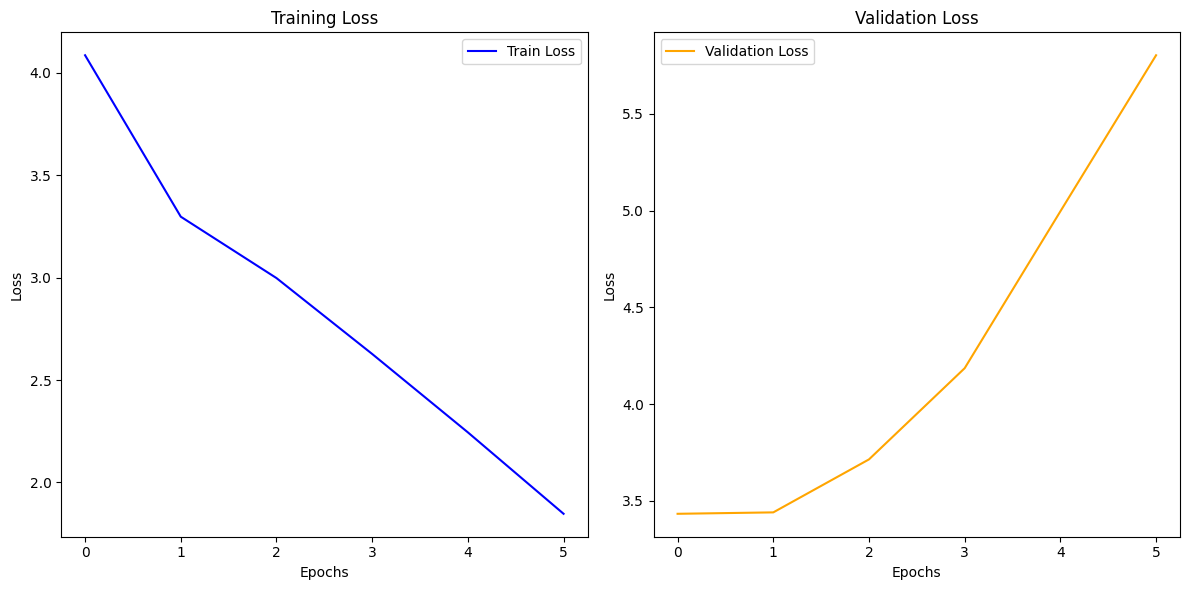

In [13]:
# plot the train loss and validation loss
import matplotlib.pyplot as plt
def plot_training_history(history):
    """Plot training and validation loss"""
    plt.figure(figsize=(12, 6))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

plot_training_history(history)


In [14]:
csv_path = "/home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/cleaned_sample.csv"
df = pd.read_csv(csv_path)
logger.info(f"Loaded {len(df)} samples from {csv_path}")

# Check for missing files and remove them
valid_files = []
for idx, row in df.iterrows():
    if os.path.exists(row['file_path']):
        valid_files.append(idx)
    else:
        logger.warning(f"File not found: {row['file_path']}")

df = df.iloc[valid_files].reset_index(drop=True)
logger.info(f"Found {len(df)} valid samples")

test_size = 0.2
random_state = 42

# Train/test split
train_df, test_df = train_test_split(
    df, test_size=test_size, random_state=random_state, stratify=None
)

INFO:__main__:Loaded 7028 samples from /home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/cleaned_sample.csv
INFO:__main__:Found 7028 valid samples


In [ ]:
train_df[]

,text,url,file_path
3977,revamped electric vehicle is displayed,https://spectrum.ieee.org/image/Mjk0ODkwMw.oct...,/home/muthuajay/Documents/GitHub/DeepLearning/...
5309,a helicopter picks up cargo from the flight de...,http://l7.alamy.com/zooms/960c50b722d942ff96ab...,/home/muthuajay/Documents/GitHub/DeepLearning/...
3404,hermit crab on the beach,http://c8.alamy.com/comp/KC10TF/hermit-crab-on...,/home/muthuajay/Documents/GitHub/DeepLearning/...
4428,prisoners working in the kitchen,http://l7.alamy.com/zooms/7fb21e7d9333475a9511...,/home/muthuajay/Documents/GitHub/DeepLearning/...
5513,players acknowledge their supporters at the en...,http://www.hindustantimes.com/rf/image_size_80...,/home/muthuajay/Documents/GitHub/DeepLearning/...
...,...,...,...
3772,posing for a plus size bride .,https://i.pinimg.com/736x/f1/74/ab/f174abdfbd9...,/home/muthuajay/Documents/GitHub/DeepLearning/...
5191,male doctor is taking syringe from someone 's ...,https://ak3.picdn.net/shutterstock/videos/9864...,/home/muthuajay/Documents/GitHub/DeepLearning/...
5226,ever wake up to a numb arm ? here 's what 's h...,https://s-media-cache-ak0.pinimg.com/736x/d3/b...,/home/muthuajay/Documents/GitHub/DeepLearning/...
5390,greetings cards for birthday - let us celebrat...,https://www.messageswishesgreetings.com/images...,/home/muthuajay/Documents/GitHub/DeepLearning/...


Loaded 7028 samples from /home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/cleaned_sample.csv
Train: 5622, Test: 1406
🔍 STARTING TEXT SIMILARITY ANALYSIS
📊 EXACT MATCHES ANALYSIS
Total unique train texts: 5571
Total unique test texts: 1404
Exact matches: 13
Percentage of test texts with exact matches: 0.93%

⚠️  WARNING: Found 13 exact matches!
Sample exact matches:
  1. 'region on the edge is world renowned for its adventure'
  2. 'a skier carves a turn sending snow spraying into the air in the ski resort'
  3. 'actor and daughters uk premiere held'
  4. 'sale special offer off sign over art brush acrylic stroke paint abstract texture background vector illustration'
  5. 'actor arrives to the premiere'

📊 TF-IDF SIMILARITY ANALYSIS
Max similarity statistics:
  Mean: 0.4976
  Median: 0.4699
  Std: 0.1531
  Min: 0.0000
  Max: 1.0000

Texts with similarity > 0.8: 66 (4.69%)
⚠️  Warning: High similarity detected!

📊 VOCABULARY OVERLAP ANALYSIS
Unique words in train: 6572
Unique 

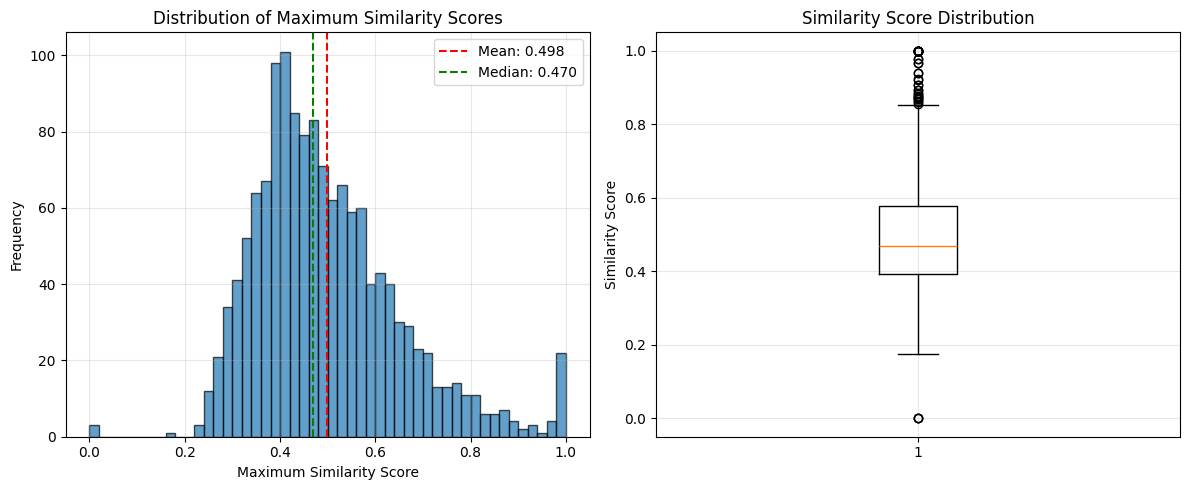


🎯 RECOMMENDATIONS
⚠️  Issues detected:
   ❌ 13 exact text matches found
   ❌ 32 very high similarity pairs (>0.9)

💡 Recommendations:
   1. Consider removing exact duplicates
   2. Use stratified splitting based on image categories if available
   3. Consider domain-based splitting (e.g., different image sources)
   4. Manual review of high-similarity pairs
   5. Consider using a held-out test set from different domain

✅ Analysis complete! Check 'text_similarity_analysis.png' for plots.


In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

class TextSimilarityAnalyzer:
    def __init__(self, train_df, test_df, text_column='text'):
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.text_column = text_column
        self.stop_words = set(stopwords.words('english'))
        
        # Clean and preprocess text
        self.train_df['clean_text'] = self.train_df[text_column].apply(self.clean_text)
        self.test_df['clean_text'] = self.test_df[text_column].apply(self.clean_text)
        
    def clean_text(self, text):
        """Clean and preprocess text"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def calculate_exact_matches(self):
        """Find exact text matches between train and test"""
        train_texts = set(self.train_df['clean_text'].tolist())
        test_texts = set(self.test_df['clean_text'].tolist())
        
        exact_matches = train_texts.intersection(test_texts)
        
        print(f"📊 EXACT MATCHES ANALYSIS")
        print(f"{'='*50}")
        print(f"Total unique train texts: {len(train_texts)}")
        print(f"Total unique test texts: {len(test_texts)}")
        print(f"Exact matches: {len(exact_matches)}")
        print(f"Percentage of test texts with exact matches: {len(exact_matches)/len(test_texts)*100:.2f}%")
        
        if len(exact_matches) > 0:
            print(f"\n⚠️  WARNING: Found {len(exact_matches)} exact matches!")
            print("Sample exact matches:")
            for i, match in enumerate(list(exact_matches)[:5]):
                print(f"  {i+1}. '{match}'")
        else:
            print("✅ No exact matches found - Good!")
        
        return exact_matches
    
    def calculate_tfidf_similarity(self, max_features=5000):
        """Calculate TF-IDF based similarity"""
        # Combine all texts for vocabulary
        all_texts = self.train_df['clean_text'].tolist() + self.test_df['clean_text'].tolist()
        
        # Create TF-IDF vectorizer
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)  # Include bigrams
        )
        
        # Fit on all texts
        vectorizer.fit(all_texts)
        
        # Transform train and test texts
        train_tfidf = vectorizer.transform(self.train_df['clean_text'])
        test_tfidf = vectorizer.transform(self.test_df['clean_text'])
        
        # Calculate similarity matrix (test vs train)
        similarity_matrix = cosine_similarity(test_tfidf, train_tfidf)
        
        # Get max similarity for each test text
        max_similarities = np.max(similarity_matrix, axis=1)
        
        print(f"\n📊 TF-IDF SIMILARITY ANALYSIS")
        print(f"{'='*50}")
        print(f"Max similarity statistics:")
        print(f"  Mean: {np.mean(max_similarities):.4f}")
        print(f"  Median: {np.median(max_similarities):.4f}")
        print(f"  Std: {np.std(max_similarities):.4f}")
        print(f"  Min: {np.min(max_similarities):.4f}")
        print(f"  Max: {np.max(max_similarities):.4f}")
        
        # Count high similarity cases
        high_sim_threshold = 0.8
        high_sim_count = np.sum(max_similarities > high_sim_threshold)
        print(f"\nTexts with similarity > {high_sim_threshold}: {high_sim_count} ({high_sim_count/len(max_similarities)*100:.2f}%)")
        
        if high_sim_count > 0:
            print("⚠️  Warning: High similarity detected!")
        
        return similarity_matrix, max_similarities
    
    def calculate_word_overlap(self):
        """Calculate word-level overlap between train and test"""
        def get_words(texts):
            all_words = []
            for text in texts:
                words = word_tokenize(text.lower())
                words = [w for w in words if w.isalpha() and w not in self.stop_words]
                all_words.extend(words)
            return set(all_words)
        
        train_words = get_words(self.train_df['clean_text'])
        test_words = get_words(self.test_df['clean_text'])
        
        overlap = train_words.intersection(test_words)
        
        print(f"\n📊 VOCABULARY OVERLAP ANALYSIS")
        print(f"{'='*50}")
        print(f"Unique words in train: {len(train_words)}")
        print(f"Unique words in test: {len(test_words)}")
        print(f"Overlapping words: {len(overlap)}")
        print(f"Vocabulary overlap: {len(overlap)/len(test_words)*100:.2f}%")
        
        return train_words, test_words, overlap
    
    def find_similar_pairs(self, similarity_matrix, threshold=0.7, top_k=10):
        """Find most similar train-test pairs"""
        print(f"\n📊 TOP SIMILAR PAIRS (similarity > {threshold})")
        print(f"{'='*70}")
        
        similar_pairs = []
        
        for test_idx in range(similarity_matrix.shape[0]):
            for train_idx in range(similarity_matrix.shape[1]):
                sim = similarity_matrix[test_idx, train_idx]
                if sim > threshold:
                    similar_pairs.append({
                        'test_idx': test_idx,
                        'train_idx': train_idx,
                        'similarity': sim,
                        'test_text': self.test_df.iloc[test_idx][self.text_column][:100] + "...",
                        'train_text': self.train_df.iloc[train_idx][self.text_column][:100] + "..."
                    })
        
        # Sort by similarity
        similar_pairs = sorted(similar_pairs, key=lambda x: x['similarity'], reverse=True)
        
        if len(similar_pairs) == 0:
            print("✅ No pairs found above threshold - Good!")
            return similar_pairs
        
        print(f"Found {len(similar_pairs)} pairs above threshold")
        print(f"\nTop {min(top_k, len(similar_pairs))} most similar pairs:")
        
        for i, pair in enumerate(similar_pairs[:top_k]):
            print(f"\n{i+1}. Similarity: {pair['similarity']:.4f}")
            print(f"   Test:  {pair['test_text']}")
            print(f"   Train: {pair['train_text']}")
        
        return similar_pairs
    
    def plot_similarity_distribution(self, max_similarities):
        """Plot similarity distribution"""
        plt.figure(figsize=(12, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(max_similarities, bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(np.mean(max_similarities), color='red', linestyle='--', label=f'Mean: {np.mean(max_similarities):.3f}')
        plt.axvline(np.median(max_similarities), color='green', linestyle='--', label=f'Median: {np.median(max_similarities):.3f}')
        plt.xlabel('Maximum Similarity Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Maximum Similarity Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Box plot
        plt.subplot(1, 2, 2)
        plt.boxplot(max_similarities)
        plt.ylabel('Similarity Score')
        plt.title('Similarity Score Distribution')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('text_similarity_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def analyze_caption_patterns(self):
        """Analyze common patterns in captions"""
        def get_pattern_stats(texts):
            # Length statistics
            lengths = [len(text.split()) for text in texts]
            
            # Common starting words
            start_words = [text.split()[0] if text.split() else '' for text in texts]
            start_word_counts = Counter(start_words)
            
            # Common phrases (3-grams)
            trigrams = []
            for text in texts:
                words = text.split()
                for i in range(len(words) - 2):
                    trigrams.append(' '.join(words[i:i+3]))
            trigram_counts = Counter(trigrams)
            
            return {
                'avg_length': np.mean(lengths),
                'length_std': np.std(lengths),
                'top_starts': start_word_counts.most_common(5),
                'top_trigrams': trigram_counts.most_common(5)
            }
        
        train_stats = get_pattern_stats(self.train_df['clean_text'])
        test_stats = get_pattern_stats(self.test_df['clean_text'])
        
        print(f"\n📊 CAPTION PATTERN ANALYSIS")
        print(f"{'='*50}")
        print(f"Train set:")
        print(f"  Avg length: {train_stats['avg_length']:.1f} ± {train_stats['length_std']:.1f} words")
        print(f"  Top starting words: {train_stats['top_starts']}")
        
        print(f"\nTest set:")
        print(f"  Avg length: {test_stats['avg_length']:.1f} ± {test_stats['length_std']:.1f} words")
        print(f"  Top starting words: {test_stats['top_starts']}")
        
        # Check for common patterns
        train_trigrams = set([t[0] for t in train_stats['top_trigrams']])
        test_trigrams = set([t[0] for t in test_stats['top_trigrams']])
        common_patterns = train_trigrams.intersection(test_trigrams)
        
        if common_patterns:
            print(f"\n⚠️  Common phrase patterns found: {len(common_patterns)}")
            for pattern in list(common_patterns)[:3]:
                print(f"  - '{pattern}'")
        
        return train_stats, test_stats
    
    def generate_recommendations(self, exact_matches, max_similarities, similar_pairs):
        """Generate recommendations based on analysis"""
        print(f"\n🎯 RECOMMENDATIONS")
        print(f"{'='*50}")
        
        # Check for issues
        issues = []
        
        if len(exact_matches) > 0:
            issues.append(f"❌ {len(exact_matches)} exact text matches found")
        
        high_sim_count = np.sum(max_similarities > 0.8)
        if high_sim_count > len(max_similarities) * 0.05:  # More than 5%
            issues.append(f"❌ {high_sim_count} high similarity pairs (>0.8)")
        
        very_high_sim = np.sum(max_similarities > 0.9)
        if very_high_sim > 0:
            issues.append(f"❌ {very_high_sim} very high similarity pairs (>0.9)")
        
        if len(issues) == 0:
            print("✅ No major issues detected!")
            print("✅ The train/test split looks good for CLIP validation")
        else:
            print("⚠️  Issues detected:")
            for issue in issues:
                print(f"   {issue}")
            
            print("\n💡 Recommendations:")
            print("   1. Consider removing exact duplicates")
            print("   2. Use stratified splitting based on image categories if available")
            print("   3. Consider domain-based splitting (e.g., different image sources)")
            print("   4. Manual review of high-similarity pairs")
            print("   5. Consider using a held-out test set from different domain")
    
    def run_full_analysis(self):
        """Run complete similarity analysis"""
        print("🔍 STARTING TEXT SIMILARITY ANALYSIS")
        print("="*60)
        
        # 1. Exact matches
        exact_matches = self.calculate_exact_matches()
        
        # 2. TF-IDF similarity
        similarity_matrix, max_similarities = self.calculate_tfidf_similarity()
        
        # 3. Word overlap
        train_words, test_words, overlap = self.calculate_word_overlap()
        
        # 4. Similar pairs
        similar_pairs = self.find_similar_pairs(similarity_matrix)
        
        # 5. Caption patterns
        train_stats, test_stats = self.analyze_caption_patterns()
        
        # 6. Plot results
        self.plot_similarity_distribution(max_similarities)
        
        # 7. Recommendations
        self.generate_recommendations(exact_matches, max_similarities, similar_pairs)
        
        return {
            'exact_matches': exact_matches,
            'similarity_matrix': similarity_matrix,
            'max_similarities': max_similarities,
            'similar_pairs': similar_pairs,
            'vocabulary_overlap': len(overlap) / len(test_words),
            'train_stats': train_stats,
            'test_stats': test_stats
        }

def analyze_text_similarity_from_csv(csv_path, text_column='text', test_size=0.2, random_state=42):
    """
    Analyze text similarity for a CSV file with train/test split
    """
    # Load data
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} samples from {csv_path}")
    
    # Create train/test split
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=random_state
    )
    
    print(f"Train: {len(train_df)}, Test: {len(test_df)}")
    
    # Run analysis
    analyzer = TextSimilarityAnalyzer(train_df, test_df, text_column)
    results = analyzer.run_full_analysis()
    
    return analyzer, results

# Example usage
if __name__ == "__main__":
    # Replace with your CSV path
    csv_path = "/home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/cleaned_sample.csv"
    
    # Run analysis
    analyzer, results = analyze_text_similarity_from_csv(
        csv_path=csv_path,
        text_column='text',
        test_size=0.2,
        random_state=42
    )
    
    print("\n" + "="*60)
    print("✅ Analysis complete! Check 'text_similarity_analysis.png' for plots.")

In [17]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/muthuajay/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [18]:
nltk.data.find('tokenizers/punkt')
nltk.data.find('corpora/stopwords')

FileSystemPathPointer('/home/muthuajay/nltk_data/corpora/stopwords')

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Loaded 7028 samples: Train=5622, Test=1406
🚀 STARTING COMPREHENSIVE EMBEDDING SIMILARITY ANALYSIS
🔄 Generating embeddings with multiple models...
Generating SentenceBERT embeddings for 5622 texts...


Batches: 100%|██████████| 176/176 [00:00<00:00, 433.29it/s]
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Generating SentenceBERT embeddings for 1406 texts...


Batches: 100%|██████████| 44/44 [00:00<00:00, 431.27it/s]


Generating CLIP text embeddings for 5622 texts...


100%|██████████| 176/176 [00:01<00:00, 161.50it/s]


Generating CLIP text embeddings for 1406 texts...


100%|██████████| 44/44 [00:00<00:00, 145.21it/s]


Generating BERT embeddings for 5622 texts...


100%|██████████| 352/352 [00:01<00:00, 225.82it/s]


Generating BERT embeddings for 1406 texts...


100%|██████████| 88/88 [00:00<00:00, 226.88it/s]


✅ All embeddings generated!
📊 Calculating sentence_bert similarities...

📈 SENTENCE_BERT SIMILARITY STATISTICS:
Mean max similarity: 0.6084
Median max similarity: 0.5976
Std max similarity: 0.1125
Min similarity: 0.3003
Max similarity: 1.0000
Samples with similarity > 0.9: 30 (2.1%)
Samples with similarity > 0.8: 74 (5.3%)
Samples with similarity > 0.7: 232 (16.5%)
Samples with similarity > 0.6: 691 (49.1%)
📊 Calculating clip_text similarities...

📈 CLIP_TEXT SIMILARITY STATISTICS:
Mean max similarity: 0.7029
Median max similarity: 0.6991
Std max similarity: 0.0962
Min similarity: 0.4134
Max similarity: 1.0000
Samples with similarity > 0.9: 44 (3.1%)
Samples with similarity > 0.8: 194 (13.8%)
Samples with similarity > 0.7: 700 (49.8%)
Samples with similarity > 0.6: 1217 (86.6%)
📊 Calculating bert similarities...

📈 BERT SIMILARITY STATISTICS:
Mean max similarity: 0.8213
Median max similarity: 0.8200
Std max similarity: 0.0550
Min similarity: 0.5974
Max similarity: 1.0000
Samples with s

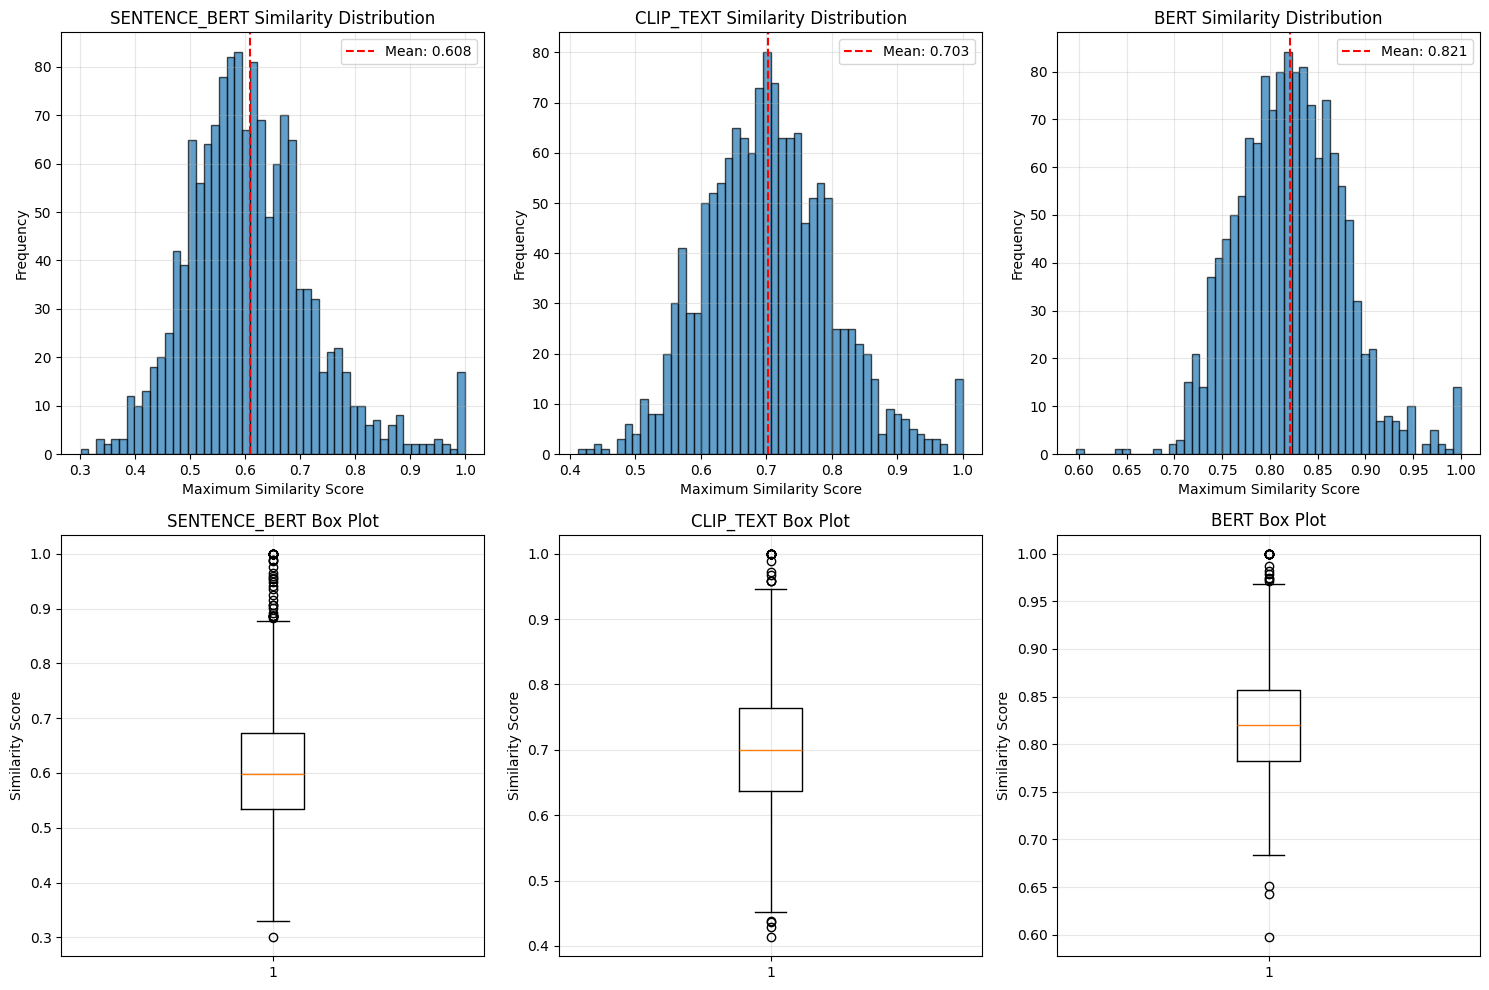

Could not create visualization for sentence_bert
Could not create visualization for clip_text

🎯 CLUSTER ANALYSIS (SENTENCE_BERT)
   Cluster  Train_Count  Test_Count  Train_Pct   Test_Pct  Difference
0        0         1331         357  23.674849  25.391181    1.716332
1        1         1430         347  25.435788  24.679943    0.755845
2        2          956         237  17.004625  16.856330    0.148295
3        3         1071         256  19.050160  18.207681    0.842479
4        4          834         209  14.834578  14.864865    0.030286

Average cluster distribution difference: 0.70%
✅ Cluster distributions are reasonably balanced

🎯 CLUSTER ANALYSIS (CLIP_TEXT)
   Cluster  Train_Count  Test_Count  Train_Pct   Test_Pct  Difference
0        0          470         131   8.360014   9.317212    0.957198
1        1         1221         290  21.718250  20.625889    1.092361
2        2         1312         335  23.336891  23.826458    0.489567
3        3          985         257  17.52

In [22]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class EmbeddingSimilarityAnalyzer:
    def __init__(self, train_df, test_df, text_column='text', device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.text_column = text_column
        self.device = device
        
        # Initialize embedding models
        self.embedding_models = {
            'sentence_bert': 'sentence-transformers/all-MiniLM-L6-v2',
            'clip_text': 'openai/clip-vit-base-patch32',  # For CLIP text encoder
            'bert': 'bert-base-uncased'
        }
        
        self.embeddings = {}
        
    def get_sentence_bert_embeddings(self, texts, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        """Get SentenceBERT embeddings (most semantic)"""
        try:
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer(model_name)
            
            print(f"Generating SentenceBERT embeddings for {len(texts)} texts...")
            embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=True)
            return embeddings.cpu().numpy()
        
        except ImportError:
            print("SentenceTransformers not installed. Install with: pip install sentence-transformers")
            return None
    
    def get_clip_text_embeddings(self, texts):
        """Get CLIP text embeddings"""
        try:
            from transformers import CLIPTokenizer, CLIPTextModel
            
            tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
            model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')
            model = model.to(self.device)
            model.eval()
            
            embeddings = []
            batch_size = 32
            
            print(f"Generating CLIP text embeddings for {len(texts)} texts...")
            
            with torch.no_grad():
                for i in tqdm(range(0, len(texts), batch_size)):
                    batch_texts = texts[i:i+batch_size]
                    inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                                     max_length=77, return_tensors="pt")
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    
                    outputs = model(**inputs)
                    # Use pooled output (CLS token equivalent)
                    batch_embeddings = outputs.pooler_output
                    embeddings.append(batch_embeddings.cpu().numpy())
            
            return np.vstack(embeddings)
        
        except ImportError:
            print("Transformers not installed or CLIP model unavailable")
            return None
    
    def get_bert_embeddings(self, texts, model_name='bert-base-uncased'):
        """Get BERT embeddings with mean pooling"""
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model = model.to(self.device)
        model.eval()
        
        embeddings = []
        batch_size = 16
        
        print(f"Generating BERT embeddings for {len(texts)} texts...")
        
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size)):
                batch_texts = texts[i:i+batch_size]
                inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                                 max_length=512, return_tensors="pt")
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                outputs = model(**inputs)
                # Mean pooling
                attention_mask = inputs['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                batch_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                
                embeddings.append(batch_embeddings.cpu().numpy())
        
        return np.vstack(embeddings)
    
    def generate_all_embeddings(self):
        """Generate embeddings using multiple models"""
        train_texts = self.train_df[self.text_column].astype(str).tolist()
        test_texts = self.test_df[self.text_column].astype(str).tolist()
        
        print("🔄 Generating embeddings with multiple models...")
        
        # SentenceBERT (best for semantic similarity)
        train_sbert = self.get_sentence_bert_embeddings(train_texts)
        test_sbert = self.get_sentence_bert_embeddings(test_texts)
        
        if train_sbert is not None:
            self.embeddings['sentence_bert'] = {
                'train': train_sbert,
                'test': test_sbert
            }
        
        # CLIP Text Embeddings (most relevant for CLIP training)
        train_clip = self.get_clip_text_embeddings(train_texts)
        test_clip = self.get_clip_text_embeddings(test_texts)
        
        if train_clip is not None:
            self.embeddings['clip_text'] = {
                'train': train_clip,
                'test': test_clip
            }
        
        # BERT embeddings
        train_bert = self.get_bert_embeddings(train_texts)
        test_bert = self.get_bert_embeddings(test_texts)
        
        self.embeddings['bert'] = {
            'train': train_bert,
            'test': test_bert
        }
        
        print("✅ All embeddings generated!")
    
    def calculate_embedding_similarities(self, embedding_type='sentence_bert'):
        """Calculate cosine similarities between train and test embeddings"""
        if embedding_type not in self.embeddings:
            print(f"❌ {embedding_type} embeddings not available")
            return None, None
        
        train_emb = self.embeddings[embedding_type]['train']
        test_emb = self.embeddings[embedding_type]['test']
        
        print(f"📊 Calculating {embedding_type} similarities...")
        
        # Calculate similarity matrix (test vs train)
        similarity_matrix = cosine_similarity(test_emb, train_emb)
        
        # Get max similarity for each test sample
        max_similarities = np.max(similarity_matrix, axis=1)
        
        print(f"\n📈 {embedding_type.upper()} SIMILARITY STATISTICS:")
        print(f"{'='*50}")
        print(f"Mean max similarity: {np.mean(max_similarities):.4f}")
        print(f"Median max similarity: {np.median(max_similarities):.4f}")
        print(f"Std max similarity: {np.std(max_similarities):.4f}")
        print(f"Min similarity: {np.min(max_similarities):.4f}")
        print(f"Max similarity: {np.max(max_similarities):.4f}")
        
        # Analyze high similarity cases
        thresholds = [0.9, 0.8, 0.7, 0.6]
        for threshold in thresholds:
            count = np.sum(max_similarities > threshold)
            percentage = count / len(max_similarities) * 100
            print(f"Samples with similarity > {threshold}: {count} ({percentage:.1f}%)")
        
        return similarity_matrix, max_similarities
    
    def find_most_similar_pairs(self, similarity_matrix, embedding_type, top_k=10, threshold=0.7):
        """Find and display most similar train-test pairs"""
        print(f"\n🔍 TOP SIMILAR PAIRS ({embedding_type.upper()}, similarity > {threshold})")
        print(f"{'='*80}")
        
        similar_pairs = []
        
        for test_idx in range(similarity_matrix.shape[0]):
            train_idx = np.argmax(similarity_matrix[test_idx])
            max_sim = similarity_matrix[test_idx, train_idx]
            
            if max_sim > threshold:
                similar_pairs.append({
                    'test_idx': test_idx,
                    'train_idx': train_idx,
                    'similarity': max_sim,
                    'test_text': self.test_df.iloc[test_idx][self.text_column],
                    'train_text': self.train_df.iloc[train_idx][self.text_column]
                })
        
        # Sort by similarity
        similar_pairs = sorted(similar_pairs, key=lambda x: x['similarity'], reverse=True)
        
        if len(similar_pairs) == 0:
            print("✅ No pairs found above threshold!")
            return similar_pairs
        
        print(f"Found {len(similar_pairs)} pairs above threshold")
        print(f"\nTop {min(top_k, len(similar_pairs))} most similar pairs:")
        
        for i, pair in enumerate(similar_pairs[:top_k]):
            print(f"\n{i+1}. Similarity: {pair['similarity']:.4f}")
            print(f"   Test:  {pair['test_text'][:150]}...")
            print(f"   Train: {pair['train_text'][:150]}...")
        
        return similar_pairs
    
    def visualize_embedding_space(self, embedding_type='sentence_bert', n_components=2):
        """Visualize embedding space using PCA"""
        if embedding_type not in self.embeddings:
            print(f"❌ {embedding_type} embeddings not available")
            return
        
        train_emb = self.embeddings[embedding_type]['train']
        test_emb = self.embeddings[embedding_type]['test']
        
        # Combine embeddings
        all_embeddings = np.vstack([train_emb, test_emb])
        labels = ['Train'] * len(train_emb) + ['Test'] * len(test_emb)
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(all_embeddings)
        
        # Create interactive plot
        if n_components == 2:
            fig = px.scatter(
                x=reduced_embeddings[:, 0],
                y=reduced_embeddings[:, 1],
                color=labels,
                title=f'{embedding_type.upper()} Embedding Space (PCA)',
                labels={'x': f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
                       'y': f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)'},
                opacity=0.6
            )
        else:  # 3D
            fig = px.scatter_3d(
                x=reduced_embeddings[:, 0],
                y=reduced_embeddings[:, 1],
                z=reduced_embeddings[:, 2],
                color=labels,
                title=f'{embedding_type.upper()} Embedding Space (PCA 3D)',
                labels={'x': f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
                       'y': f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
                       'z': f'PC3 ({pca.explained_variance_ratio_[2]:.1%})'},
                opacity=0.6
            )
        
        fig.show()
        return fig
    
    def cluster_analysis(self, embedding_type='sentence_bert', n_clusters=5):
        """Analyze clustering of train vs test embeddings"""
        if embedding_type not in self.embeddings:
            print(f"❌ {embedding_type} embeddings not available")
            return
        
        train_emb = self.embeddings[embedding_type]['train']
        test_emb = self.embeddings[embedding_type]['test']
        
        # Combine embeddings
        all_embeddings = np.vstack([train_emb, test_emb])
        
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(all_embeddings)
        
        # Analyze cluster distribution
        train_clusters = cluster_labels[:len(train_emb)]
        test_clusters = cluster_labels[len(train_emb):]
        
        print(f"\n🎯 CLUSTER ANALYSIS ({embedding_type.upper()})")
        print(f"{'='*50}")
        
        # Create cluster distribution table
        cluster_dist = pd.DataFrame({
            'Cluster': range(n_clusters),
            'Train_Count': [np.sum(train_clusters == i) for i in range(n_clusters)],
            'Test_Count': [np.sum(test_clusters == i) for i in range(n_clusters)]
        })
        
        cluster_dist['Train_Pct'] = cluster_dist['Train_Count'] / len(train_emb) * 100
        cluster_dist['Test_Pct'] = cluster_dist['Test_Count'] / len(test_emb) * 100
        cluster_dist['Difference'] = abs(cluster_dist['Train_Pct'] - cluster_dist['Test_Pct'])
        
        print(cluster_dist)
        
        # Check for imbalanced clusters
        avg_difference = cluster_dist['Difference'].mean()
        print(f"\nAverage cluster distribution difference: {avg_difference:.2f}%")
        
        if avg_difference > 10:
            print("⚠️  High cluster imbalance detected!")
            print("   Train and test sets have different semantic distributions")
        else:
            print("✅ Cluster distributions are reasonably balanced")
        
        return cluster_dist, cluster_labels
    
    def plot_similarity_distributions(self):
        """Plot similarity distributions for all embedding types"""
        n_models = len(self.embeddings)
        
        if n_models == 0:
            print("❌ No embeddings available for plotting")
            return
        
        fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))
        if n_models == 1:
            axes = axes.reshape(2, 1)
        
        for i, (emb_type, emb_data) in enumerate(self.embeddings.items()):
            # Calculate similarities
            similarity_matrix, max_similarities = self.calculate_embedding_similarities(emb_type)
            
            # Histogram
            axes[0, i].hist(max_similarities, bins=50, alpha=0.7, edgecolor='black')
            axes[0, i].axvline(np.mean(max_similarities), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(max_similarities):.3f}')
            axes[0, i].set_xlabel('Maximum Similarity Score')
            axes[0, i].set_ylabel('Frequency')
            axes[0, i].set_title(f'{emb_type.upper()} Similarity Distribution')
            axes[0, i].legend()
            axes[0, i].grid(True, alpha=0.3)
            
            # Box plot
            axes[1, i].boxplot(max_similarities)
            axes[1, i].set_ylabel('Similarity Score')
            axes[1, i].set_title(f'{emb_type.upper()} Box Plot')
            axes[1, i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('embedding_similarity_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_comprehensive_report(self):
        """Generate comprehensive similarity report"""
        print("📋 COMPREHENSIVE EMBEDDING SIMILARITY REPORT")
        print("="*70)
        
        # Summary statistics for all embedding types
        summary_stats = {}
        
        for emb_type in self.embeddings.keys():
            similarity_matrix, max_similarities = self.calculate_embedding_similarities(emb_type)
            
            summary_stats[emb_type] = {
                'mean_similarity': np.mean(max_similarities),
                'median_similarity': np.median(max_similarities),
                'std_similarity': np.std(max_similarities),
                'high_similarity_count': np.sum(max_similarities > 0.8),
                'very_high_similarity_count': np.sum(max_similarities > 0.9)
            }
            
            # Find similar pairs
            similar_pairs = self.find_most_similar_pairs(similarity_matrix, emb_type, top_k=5)
        
        # Create summary DataFrame
        summary_df = pd.DataFrame(summary_stats).T
        print(f"\n📊 SUMMARY STATISTICS:")
        print(summary_df.round(4))
        
        # Generate recommendations
        self.generate_recommendations(summary_stats)
        
        return summary_stats
    
    def generate_recommendations(self, summary_stats):
        """Generate actionable recommendations"""
        print(f"\n🎯 RECOMMENDATIONS")
        print(f"{'='*50}")
        
        # Analyze most relevant embedding type (CLIP or SentenceBERT)
        primary_emb = 'clip_text' if 'clip_text' in summary_stats else 'sentence_bert'
        if primary_emb not in summary_stats:
            primary_emb = list(summary_stats.keys())[0]
        
        stats = summary_stats[primary_emb]
        
        issues = []
        recommendations = []
        
        # Check mean similarity
        if stats['mean_similarity'] > 0.7:
            issues.append(f"❌ Very high mean similarity ({stats['mean_similarity']:.3f})")
            recommendations.append("Consider completely different data sources for test set")
        elif stats['mean_similarity'] > 0.5:
            issues.append(f"⚠️ High mean similarity ({stats['mean_similarity']:.3f})")
            recommendations.append("Review and possibly remove similar samples")
        
        # Check high similarity counts
        if stats['very_high_similarity_count'] > 0:
            issues.append(f"❌ {stats['very_high_similarity_count']} very similar pairs (>0.9)")
            recommendations.append("Remove near-duplicate samples")
        
        if stats['high_similarity_count'] > len(self.test_df) * 0.1:
            issues.append(f"⚠️ {stats['high_similarity_count']} high similarity pairs (>0.8)")
            recommendations.append("Consider stratified or domain-based splitting")
        
        # Final assessment
        if len(issues) == 0:
            print("✅ ASSESSMENT: Good train/test split for CLIP validation")
            print("✅ Semantic similarity is at acceptable levels")
        else:
            print("⚠️ ISSUES DETECTED:")
            for issue in issues:
                print(f"   {issue}")
            
            print("\n💡 RECOMMENDATIONS:")
            for rec in recommendations:
                print(f"   • {rec}")
            
            print("\n🔧 ADDITIONAL STRATEGIES:")
            print("   • Use domain-based splitting (different image sources)")
            print("   • Create test set from different time period")
            print("   • Manual curation of semantically diverse test samples")
            print("   • Consider cross-domain evaluation (e.g., different datasets)")
    
    def run_full_analysis(self):
        """Run complete embedding similarity analysis"""
        print("🚀 STARTING COMPREHENSIVE EMBEDDING SIMILARITY ANALYSIS")
        print("="*70)
        
        # Generate embeddings
        self.generate_all_embeddings()
        
        # Plot distributions
        self.plot_similarity_distributions()
        
        # Visualize embedding spaces
        for emb_type in self.embeddings.keys():
            if emb_type in ['sentence_bert', 'clip_text']:  # Most important ones
                try:
                    self.visualize_embedding_space(emb_type, n_components=2)
                except:
                    print(f"Could not create visualization for {emb_type}")
        
        # Cluster analysis
        for emb_type in self.embeddings.keys():
            self.cluster_analysis(emb_type)
        
        # Generate comprehensive report
        summary_stats = self.generate_comprehensive_report()
        
        print("\n" + "="*70)
        print("✅ Analysis complete! Check plots and recommendations above.")
        
        return summary_stats

def analyze_embedding_similarity_from_csv(csv_path, text_column='text', test_size=0.2, random_state=42):
    """Main function to analyze embedding similarity from CSV"""
    # Load data and split
    df = pd.read_csv(csv_path)
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    
    print(f"Loaded {len(df)} samples: Train={len(train_df)}, Test={len(test_df)}")
    
    # Run analysis
    analyzer = EmbeddingSimilarityAnalyzer(train_df, test_df, text_column)
    results = analyzer.run_full_analysis()
    
    return analyzer, results

# Example usage
if __name__ == "__main__":
    # Replace with your CSV path
    csv_path = "/home/muthuajay/Documents/GitHub/DeepLearning/datasets/clip/cleaned_sample.csv"
    
    analyzer, results = analyze_embedding_similarity_from_csv(
        csv_path=csv_path,
        text_column='text',
        test_size=0.2,
        random_state=42
    )